In [1]:
import sys
sys.path.append("..")

import warnings
from pathlib import Path

import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.linalg as npl
import math
import random
from scipy.stats import ttest_ind

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch

from nilearn import signal
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance, GroupSparseCovarianceCV

from bold_dementia.data.study import make_control_idx
from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices


CACHE_DIR = "/georges/memento/BIDS/derivatives/schaeffer/"

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"
CLEAN_SIGNAL = True
MACRO_LABELS = False

random.seed(1)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


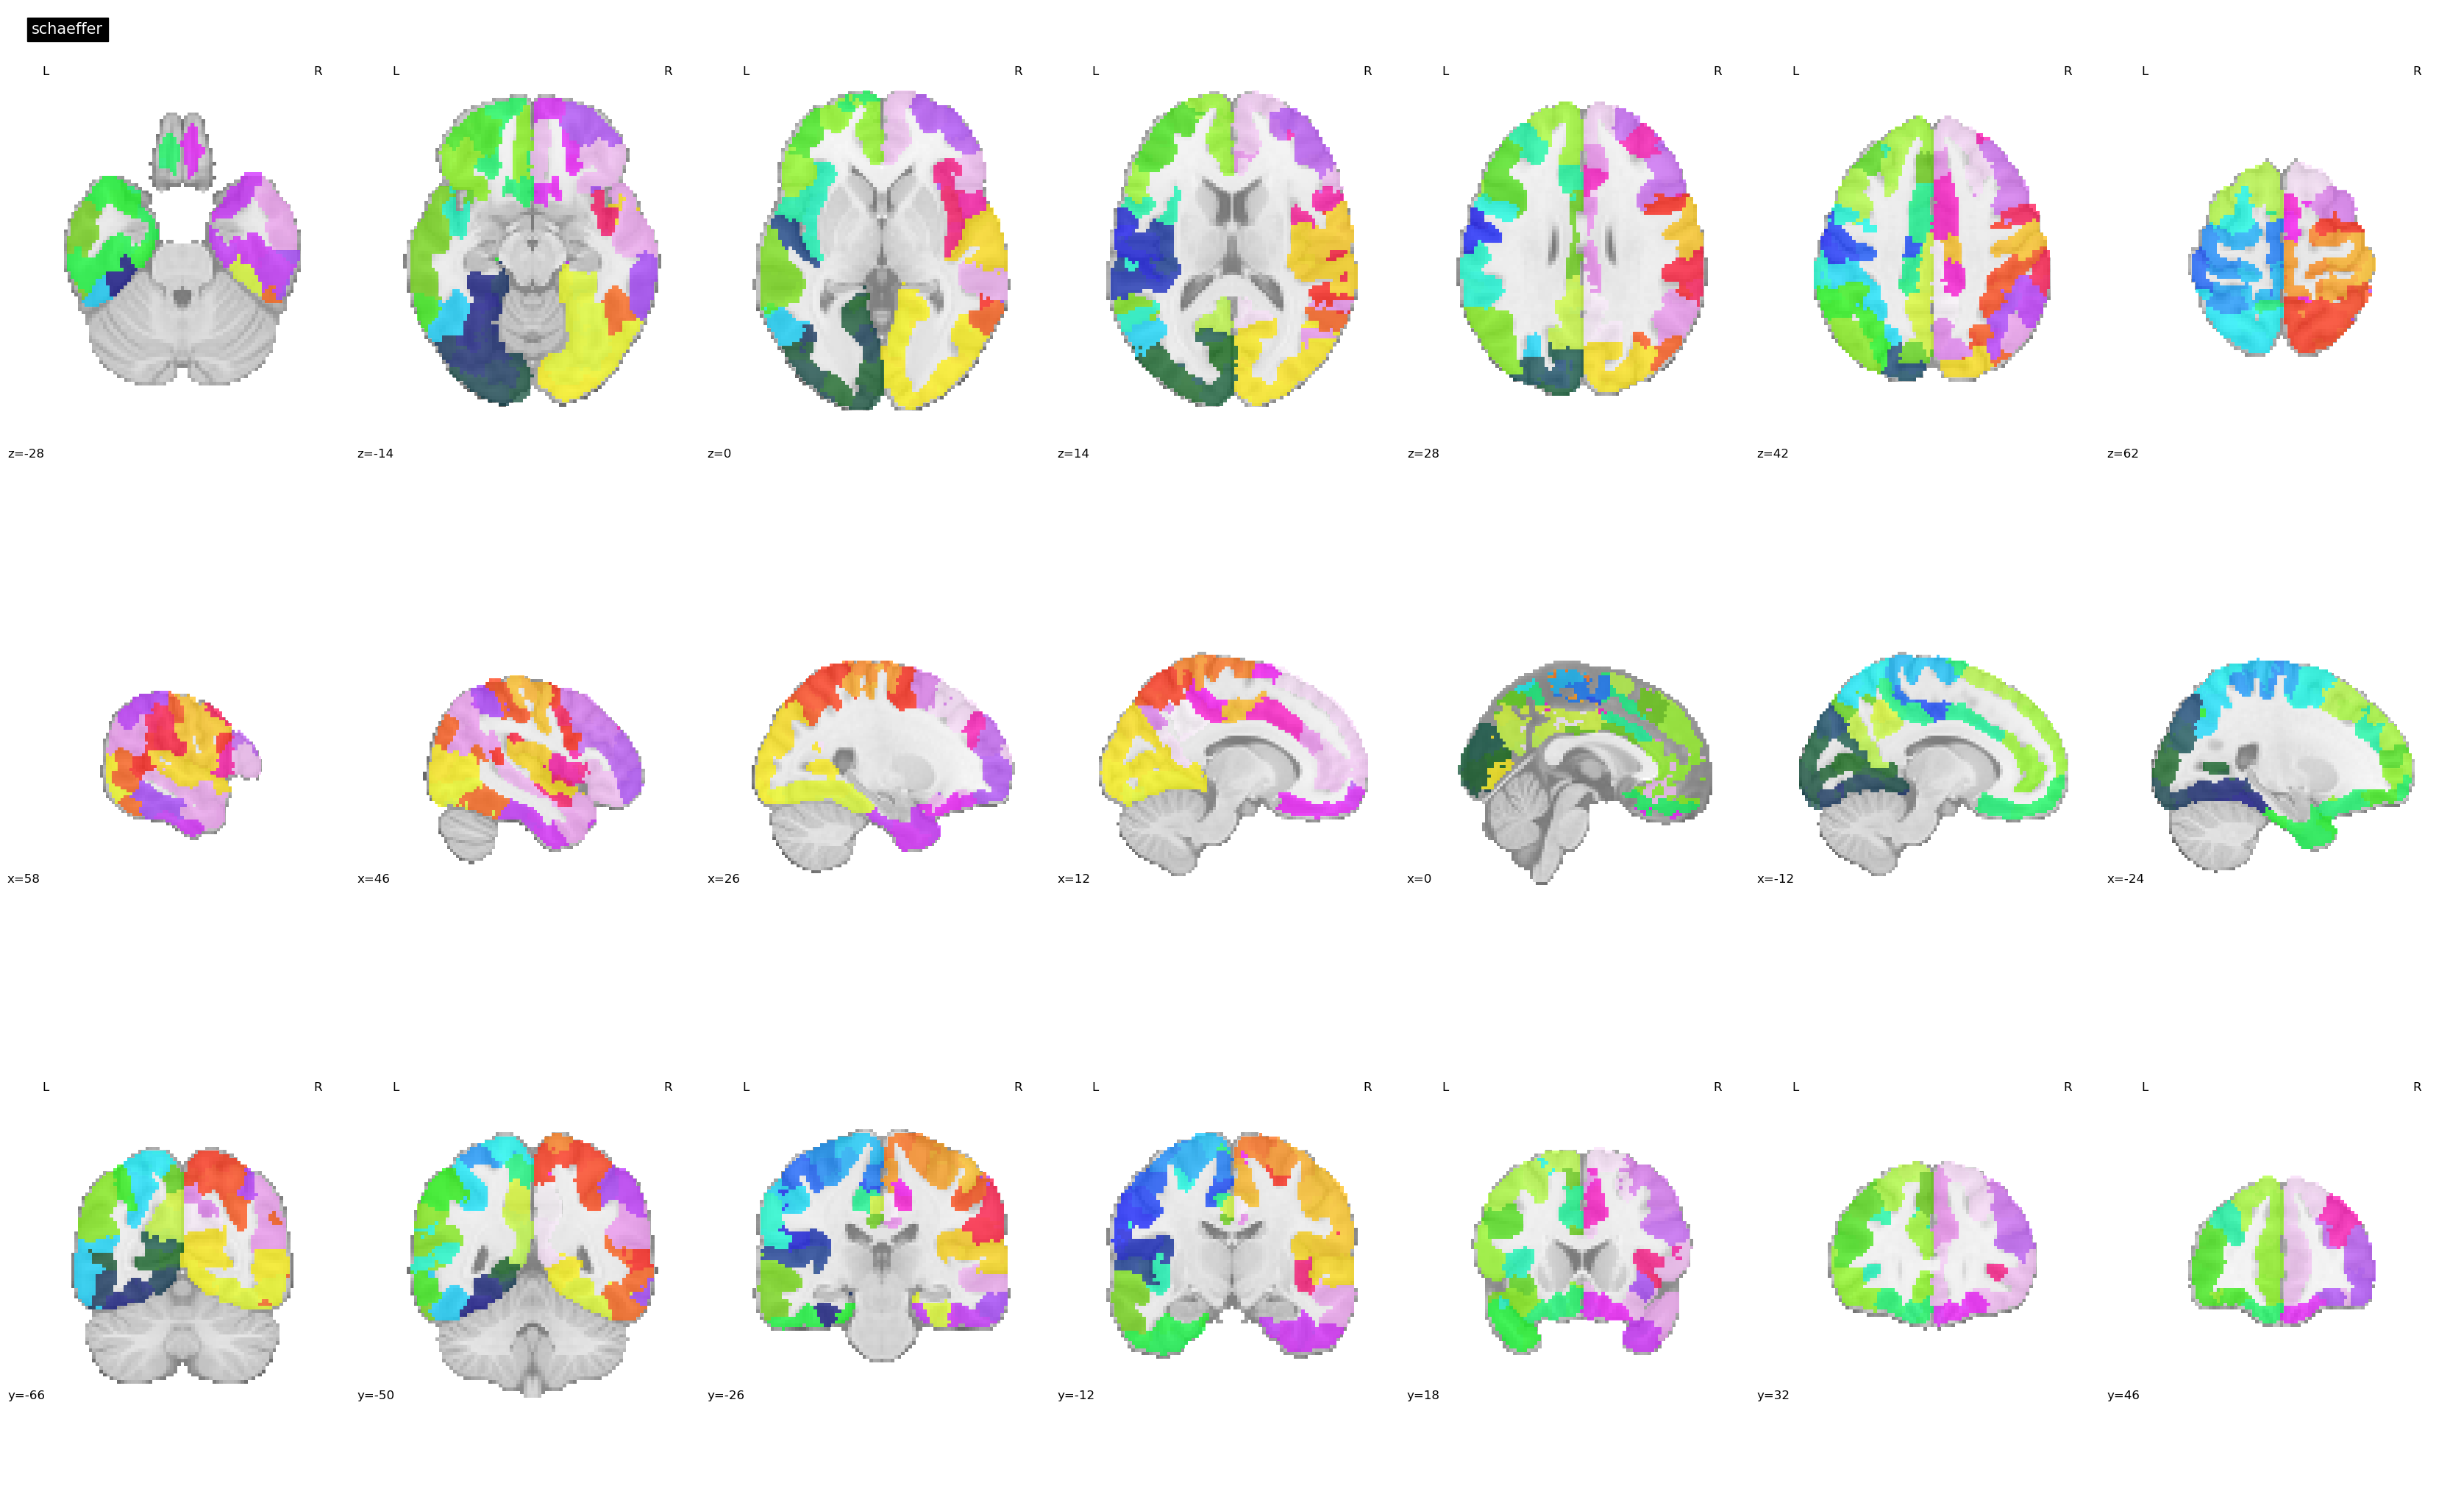

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot(display_mode="mosaic")
plotting.show()

In [3]:
def days_to_onset(row):
    return row.scan_to_onset

memento = MementoTS(cache_dir=CACHE_DIR, target_func=lambda row: row)

res = next(iter(memento))
res

(array([[662.8475 , 647.64514, 670.0993 , ..., 877.73083, 882.3985 ,
         913.4702 ],
        [658.8802 , 642.1198 , 660.2319 , ..., 871.4786 , 885.58026,
         910.0192 ],
        [656.66705, 643.5157 , 659.10895, ..., 869.2196 , 884.5311 ,
         900.2189 ],
        ...,
        [659.4836 , 647.7854 , 669.7048 , ..., 872.0773 , 886.2803 ,
         910.8693 ],
        [653.1279 , 647.9702 , 663.46655, ..., 867.3978 , 892.3242 ,
         912.53314],
        [654.3256 , 640.2316 , 662.6041 , ..., 869.99915, 888.7917 ,
         911.5599 ]], dtype=float32),
 file_path            /georges/memento/BIDS/derivatives/fmriprep-23....
 file_basename        sub-0001_ses-M000_task-rest_space-MNI152NLin6A...
 file_tag                                                          bold
 file_type                                                       nii.gz
 file_fields             ['sub', 'ses', 'task', 'space', 'res', 'desc']
 sub                                                                  

In [4]:
def load_signals(dataset, is_pos_func, is_neg_func, clean_signal=False, confounds_strategy=None):
    pos_ts = []
    neg_ts = []
    pos_meta = []
    neg_meta = []
    for ts, row, fpath in iter(dataset):
        if clean_signal:
            confounds, sample_mask = load_confounds(
                fpath, **confounds_strategy
            )
            with warnings.catch_warnings(action="ignore", category=DeprecationWarning):
                cleaned_ts = signal.clean(
                    ts,
                    sample_mask=sample_mask,
                    confounds=confounds,
                    standardize="zscore_sample"
                )
        else:
            cleaned_ts = ts
        if is_pos_func(row):
            pos_ts.append(cleaned_ts)
            pos_meta.append(row)
        elif is_neg_func(row):
            neg_ts.append(cleaned_ts)
            neg_meta.append(row)

    pos_meta = pd.DataFrame(pos_meta).reset_index(drop=True)
    neg_meta = pd.DataFrame(neg_meta).reset_index(drop=True)
    return pos_ts, neg_ts, pos_meta, neg_meta
            
    

In [5]:
def balance_control(pos, control, col_name, tol=1):
    gap = pos[col_name].mean() - control[col_name].mean()
    # Usually the age is lower in control group
    counter = 0
    while gap > tol:
        counter += 1
        print(f"#{counter}, removed age = ", end=" ")
        idx_to_drop = control[col_name].idxmin()
        print(control.loc[idx_to_drop, col_name], end=", new gap = ")
        control = control.drop(idx_to_drop)
        

        if len(control) <= len(pos):
            raise ValueError("Removed too many subjects from control")
        gap = pos[col_name].mean() - control[col_name].mean()
        print(gap, end=", ")
        print(f"{len(control)} controls left")

    return pos, control
        

In [6]:
from bold_dementia.data.memento import past_diag

def healthy_control(row):
    return math.isnan(row.scan_to_onset)

AD_signals, control_signals, pm, nm = load_signals(memento, past_diag, healthy_control, clean_signal=CLEAN_SIGNAL, confounds_strategy=confounds_strategy)

In [7]:
# We pass a control df with one scan per subject
singled_pm = pm.groupby("sub").sample(n=1, random_state=1234)
singled_nm = nm.groupby("sub").sample(n=1, random_state=1234)

# Balanced age accross group
balanced_AD, balanced_meta = balance_control(
    singled_pm,
    singled_nm,
    col_name="current_scan_age"
)
balanced_signals = [control_signals[idx] for idx in balanced_meta.index]
AD_signals = [AD_signals[idx] for idx in balanced_AD.index]

#1, removed age =  40.439726027397256, new gap = 5.135704037002611, 910 controls left
#2, removed age =  41.31780821917808, new gap = 5.101464907233833, 909 controls left
#3, removed age =  42.41643835616438, new gap = 5.068360305964461, 908 controls left
#4, removed age =  44.48767123287672, new gap = 5.037466315140705, 907 controls left
#5, removed age =  46.25342465753425, new gap = 5.008453080876549, 906 controls left
#6, removed age =  46.85479452054794, new gap = 4.980040226053845, 905 controls left
#7, removed age =  47.638356164383566, new gap = 4.952431282662744, 904 controls left
#8, removed age =  47.8054794520548, new gap = 4.924946265518486, 903 controls left
#9, removed age =  47.92876712328767, new gap = 4.897536988548211, 902 controls left
#10, removed age =  48.3, new gap = 4.870478892846293, 901 controls left
#11, removed age =  48.45205479452055, new gap = 4.843529617814482, 900 controls left
#12, removed age =  48.69178082191781, new gap = 4.8167870474293295, 899 co

In [8]:
# Merge series but keep track of indices
time_series = AD_signals + balanced_signals
AD_indices = list(range(len(AD_signals)))
control_indices = list(range(len(AD_signals), len(time_series)))
n = len(time_series)
print(f"Study on {n} subjects")

Study on 742 subjects


In [9]:
from sklearn import covariance
from bold_dementia.models.transformers import ListMixin, Concatenator
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator


# (if we can still use GroupSparseCovariance as estimator)
# Or maybe give Ledoit Wolf another chance

# The sample correlation matrix with relatively short time series
# is a bad estimate of functionnal connectivity

# TODO Add reorganisation layer to put in ConnectivityMeasure format
#pipe = Pipeline(
#    [
#        ("scaler", ListScaler()),
#        ("cov", GroupSparseCovariance(alpha=0.0011)), # alpha found by CV
#    ]
#)
pipe = ConnectivityMeasure(
    covariance.LedoitWolf(),
    kind="covariance")

# Fit AD and controls together to have a common sparsity pattern,
# but is that a good idea?
c = pipe.fit_transform(time_series)




In [10]:

# Use Bunch for compatibility with pipelines
gcov = Bunch(
    covariances_=c,
    precisions_=npl.inv(c) # I don't like this
)

In [11]:

#gcov = pipe.named_steps["cov"]
AD_cov = gcov.covariances_[AD_indices, :, :].mean(axis=0)
AD_prec = gcov.precisions_[AD_indices, :, :].mean(axis=0)

control_cov = gcov.covariances_[control_indices, :, :].mean(axis=0)
control_prec = gcov.precisions_[control_indices, :, :].mean(axis=0)

In [12]:

# TODO Macro labelling, should be added in atlases?
# TODO all those labels, refactor names
from matplotlib.ticker import FixedLocator

def plot_matrices(
    cov, prec, title, labels, macro_labels=True, cov_bounds=(-1, 1), prec_bounds=None, cmap="seismic"
    ):
    """Plot covariance and precision matrices.
    For macro labels only schaeffer has been tested so far
    """
    prec = prec.copy()  # avoid side effects
    cov = cov.copy()

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    cov[list(range(size)), list(range(size))] = 0

    span = max(abs(prec.min()), abs(prec.max()))
    if prec_bounds is None:
        prec_bounds = (-span, span)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # We want network labels to span over several rows
    if macro_labels:
        networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
        n_regions = len(labels)
        labels = None
        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax1.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax1.vlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(len(prec))

    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=cov_bounds[0], vmax=cov_bounds[1], cmap=cmap)
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap=cmap, vmin=prec_bounds[0], vmax=prec_bounds[1])

    if macro_labels:
        ax1.yaxis.set_minor_locator(FixedLocator(ticks))
        ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.set_yticklabels(lbls, rotation=0)
        ax1.set_xticklabels(lbls, rotation=30)
    
    ax1.set_title("covariance")
    ax2.set_title("precision")
    fig.suptitle(title)
    fig.tight_layout()

    return fig, ax1, ax2

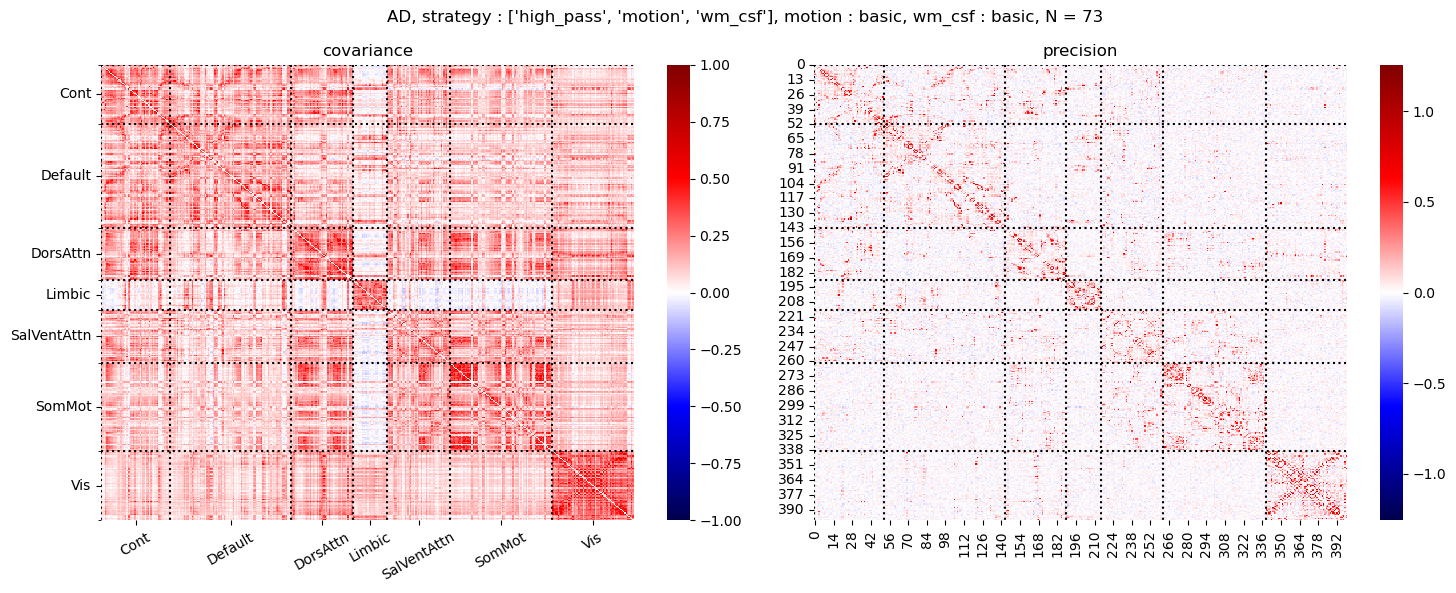

In [13]:
MACRO_LABELS = True
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_cov, -AD_prec, f"AD, {title}, N = {len(AD_signals)}", atlas.labels, macro_labels=MACRO_LABELS)

plotting.show()

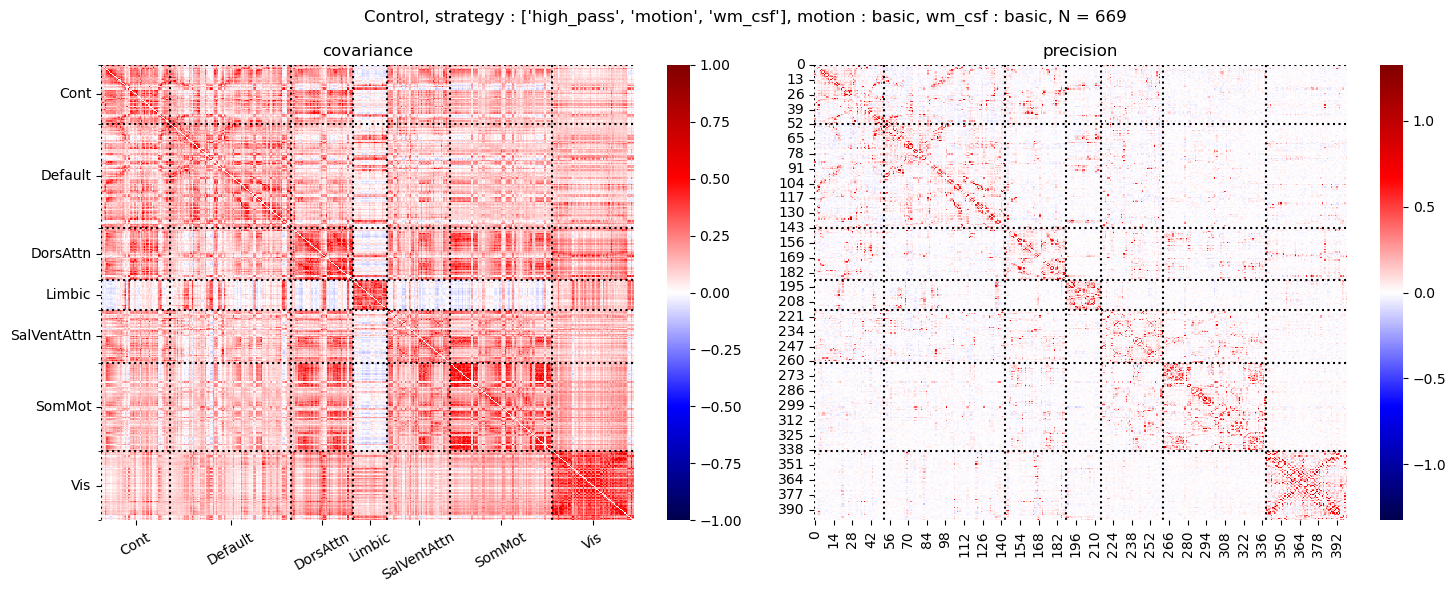

In [14]:
plot_matrices(control_cov, -control_prec, f"Control, {title}, N = {len(balanced_signals)}", atlas.labels, macro_labels=MACRO_LABELS)

plotting.show()

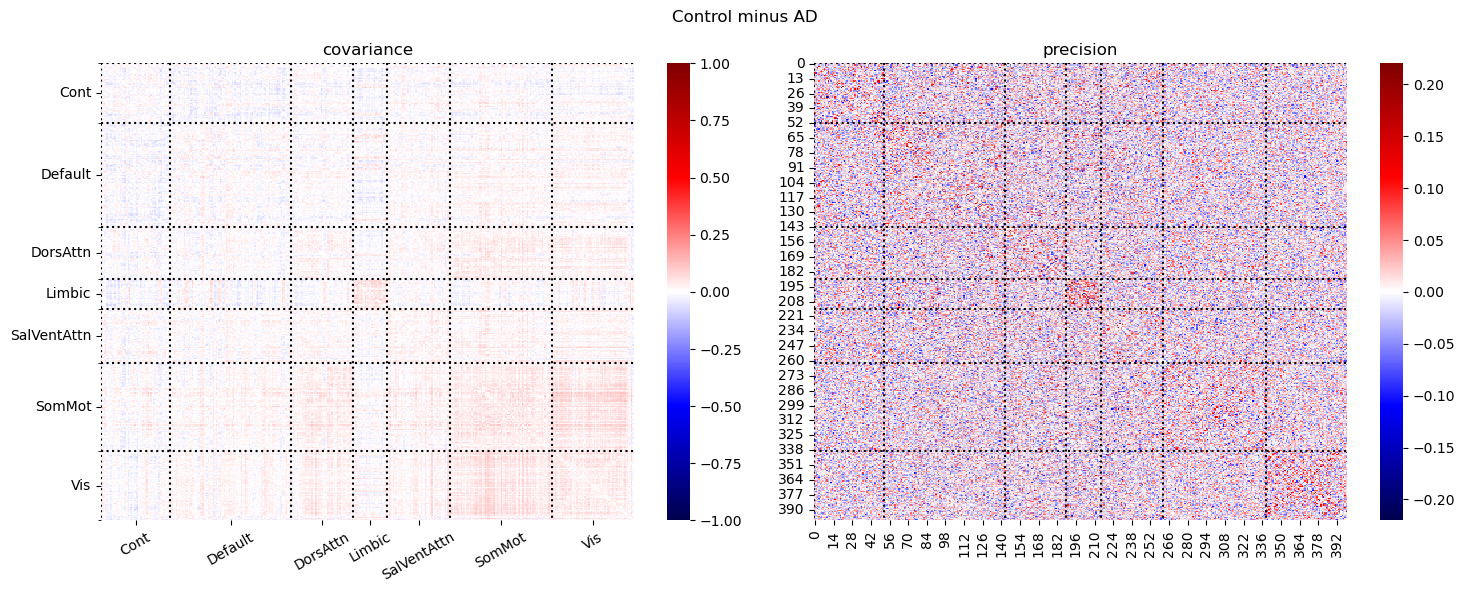

In [15]:
# TODO Same pipeline but shufle time series at the beginning to compare
# TODO Control for age?
plot_matrices(
    control_cov - AD_cov,
    -control_prec + AD_prec,
    "Control minus AD",
    atlas.labels,
    macro_labels=MACRO_LABELS
)
plotting.show()

In [16]:
cov = ttest_ind(
    gcov.covariances_[control_indices, :, :],
    gcov.covariances_[AD_indices, :, :],
    alternative="greater"
)

prec = ttest_ind(
    gcov.precisions_[control_indices, :, :],
    gcov.precisions_[AD_indices, :, :],
    alternative="greater"
)

In [99]:
from statsmodels.stats.multitest import fdrcorrection

tri_inds = np.tril_indices(len(cov[1]), k=-1)
pvalues = cov[1][tri_inds]

rejected, corrected_pvalues = fdrcorrection(
    pvalues,
    alpha=0.05
)


In [102]:
np.unique(rejected, return_counts=True)

(array([False,  True]), array([76785,  3015]))

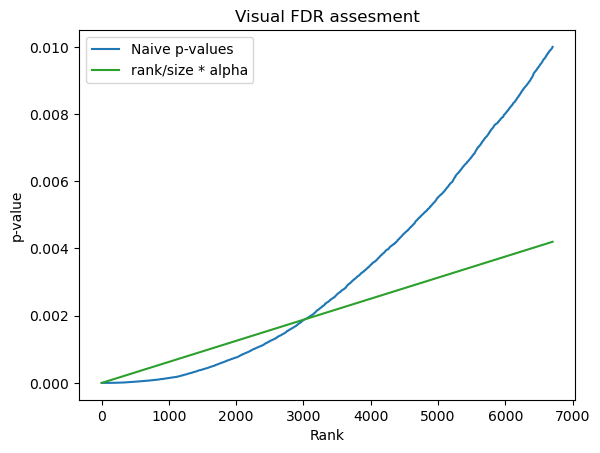

In [107]:
msk = np.where((pvalues < 0.01), True, False)
x = np.arange(pvalues[msk].size)

plt.plot(x, np.sort(pvalues[msk]), label="Naive p-values")
#plt.plot(x, np.sort(corrected_pvalues[msk]), label="FDR corrected")
#plt.plot(x, np.sort(pvalues[msk]) * pvalues.size, label="Bonferroni")
plt.plot(x, x / (pvalues.size) * 0.05, label="rank/size * alpha", color="tab:green")
plt.xlabel("Rank")
plt.ylabel("p-value")
plt.title("Visual FDR assesment")
plt.legend()
plt.show()

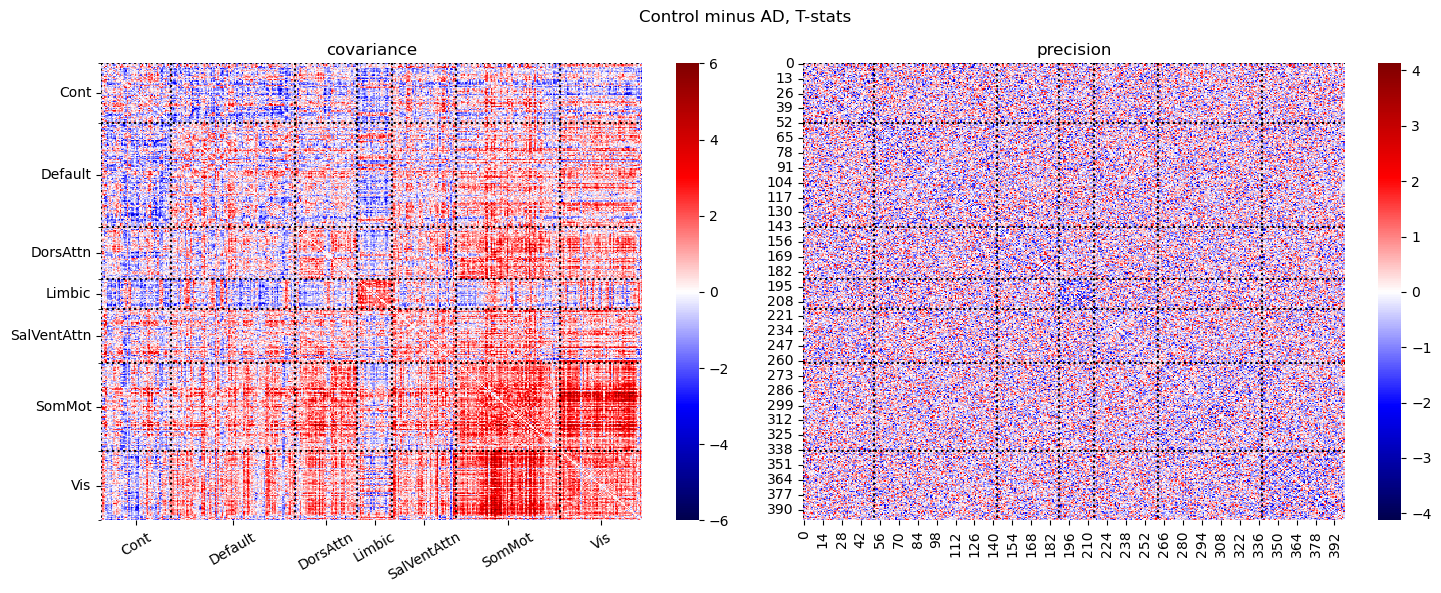

In [112]:
plot_matrices(
    cov[0],
    prec[0],
    "Control minus AD, T-stats",
    atlas.labels,
    macro_labels=MACRO_LABELS,
    cov_bounds=(-6, 6)
)
plotting.show()

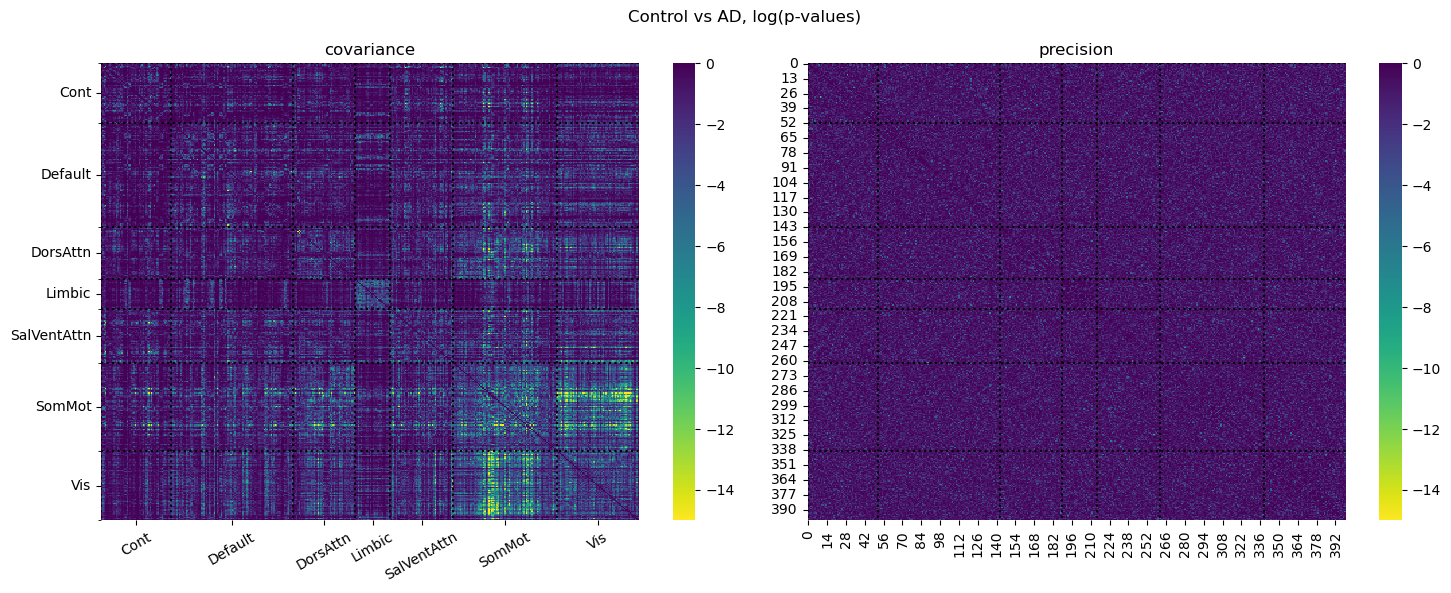

In [119]:
fig, ax1, ax2 = plot_matrices(
    np.log(cov[1]),
    np.log(prec[1]),
    "Control vs AD, log(p-values)",
    atlas.labels,
    macro_labels=MACRO_LABELS,
    cov_bounds=(-15, 0),
    prec_bounds=(-15, 0),
    cmap="viridis_r",
)
plotting.show()


In [114]:
# Bonferroni correction
alpha = 0.05
n = len(cov[1])
n_comparisons = (n**2 - n) / 2

alpha_b = alpha / n_comparisons
bonf_cov = np.where(cov[1] < alpha_b, 1, 0)
bonf_prec = np.where(prec[1] < alpha_b, 1, 0)

[]

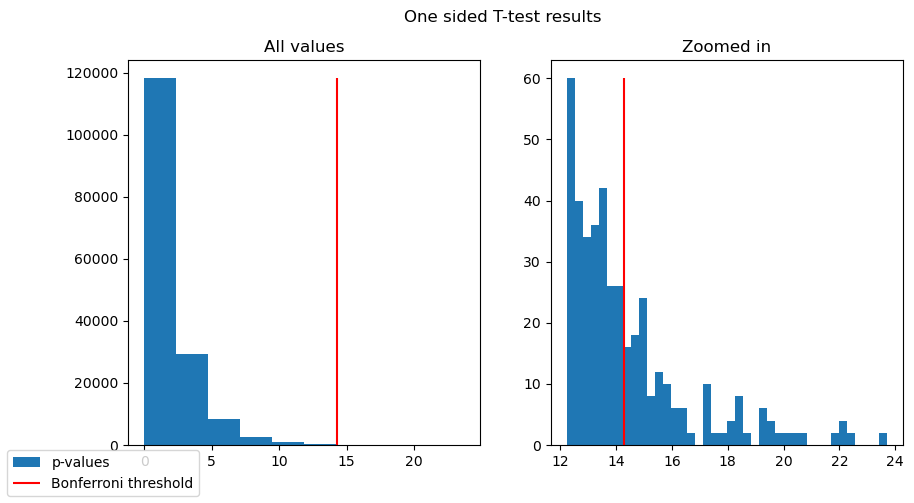

In [116]:
msk = np.where(cov[1] < alpha / 1e4, True, False) # Zoom in mask
f = lambda x: -np.log(x)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
log_tresh = f(alpha_b)
n, bins, patches = axes[0].hist(f(cov[1].flatten()), bins=10, label="p-values")
axes[0].vlines(log_tresh, 0, max(n), color="red", label="Bonferroni threshold")
axes[0].set_title("All values")

n, bins, patches = axes[1].hist(f(cov[1][msk].flatten()), bins=40)
axes[1].vlines(log_tresh, 0, max(n), color="red")
axes[1].set_title("Zoomed in")

fig.legend(loc="lower left")
fig.suptitle("One sided T-test results")
plt.plot()

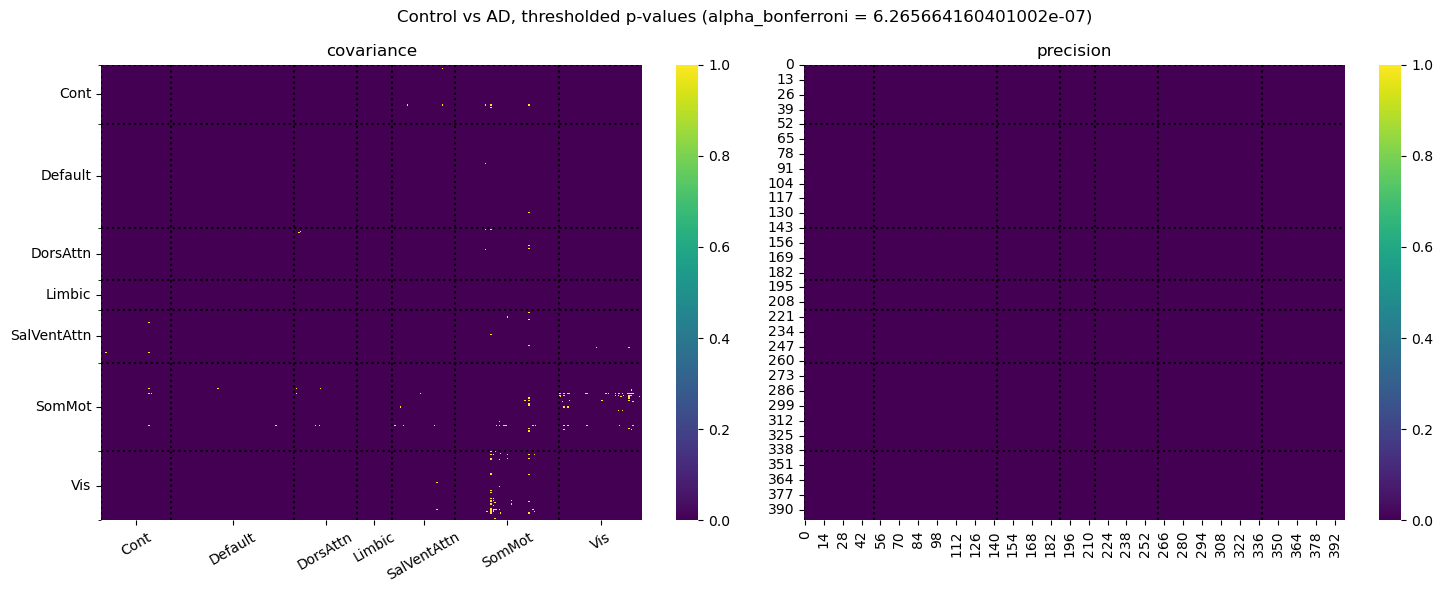

In [117]:
fig, ax1, ax2 = plot_matrices(
    bonf_cov,
    bonf_prec,
    f"Control vs AD, thresholded p-values (alpha_bonferroni = {alpha_b})",
    atlas.labels,
    macro_labels=MACRO_LABELS,
    cov_bounds=(0, 1),
    prec_bounds=(0, 1),
    cmap="viridis",
)
